2024.3.21
x.min()=-32, x.max()=31, Integer.that_can_represent(x).bit_width=6


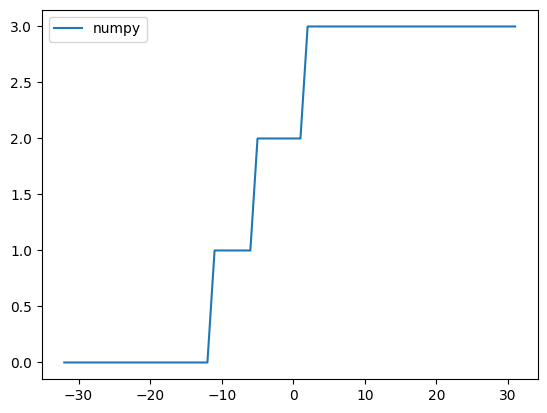

In [1]:
%matplotlib inline
from concrete.fhe import Compiler, round_bit_pattern, truncate_bit_pattern
import numpy as np
import matplotlib.pyplot as plt
from concrete.ml.common.preprocessors import (
    CycleDetector,
    GraphProcessor,
    InsertRounding,
    TLUDeltaBasedOptimizer,
)
from concrete.fhe import Exactness, Configuration
from typing import List
from importlib.metadata import version
from concrete.fhe import Integer

print(version("concrete-python"))

def relu(x):
    # return (x>0) * x
    return np.where(x>0,x,0.)

x_min, x_max = -23 , 52
x_min, x_max = -32, 32
bias=2.3
scale=0.01 # Two levels
scale=0.05 # Three levels
scale=0.15 # Four levels
n_bits=3
rounding_function = round_bit_pattern

def f(x,):
    x = x.astype(np.float64) # open tlu
    x = x*scale + bias
    x = relu(x)
    x = np.clip(x, -2**(n_bits-1), 2**(n_bits-1)-1)
    x = np.round(x)
    x = x.astype(np.int64) # close tlu
    return x

x = np.arange(x_min, x_max)
print(f"{x.min()=}, {x.max()=}, {Integer.that_can_represent(x).bit_width=}")
compile_input = x[...,np.newaxis]
y = f(x)
fig, ax = plt.subplots()
ax.plot(x, y, label="numpy")
plt.legend()
plt.show()
plt.close(fig)

In [2]:
compiler = Compiler(f,{"x": "encrypted"})
circuit = compiler.compile(compile_input)

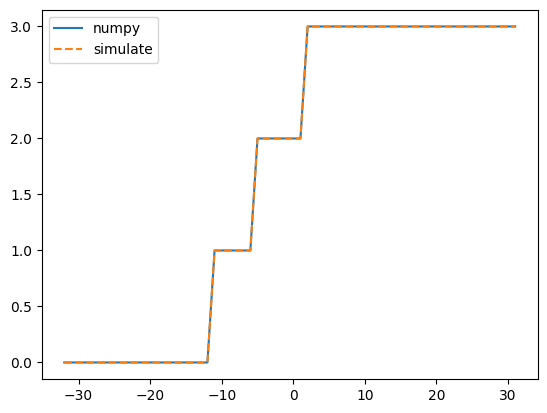

In [3]:
y_sim = np.array([circuit.simulate(elt) for elt in compile_input])[:, 0]
fig, ax = plt.subplots()
ax.plot(x, y, label="numpy",)
ax.plot(x, y_sim, label="simulate", linestyle="--",)
plt.legend()
plt.show()
plt.close(fig)

In [4]:
insert_rounding = InsertRounding(threshold=4, exactness=Exactness.EXACT)
cycle_detector = CycleDetector()
additional_pre_processors: List[GraphProcessor] = [insert_rounding]
additional_post_processors: List[GraphProcessor] = [cycle_detector]
compilation_configuration = Configuration(
    additional_pre_processors=additional_pre_processors,
    additional_post_processors=additional_post_processors,
    
)

compiler_round = Compiler(f,{"x": "encrypted"})
circuit_round = compiler_round.compile(compile_input, configuration=compilation_configuration)

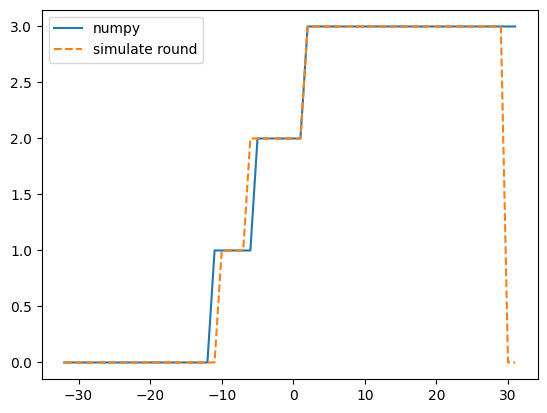

In [5]:
y_sim_round = np.array([circuit_round.simulate(elt) for elt in compile_input])[:, 0]
fig, ax = plt.subplots()
ax.plot(x, y, label="numpy",)
ax.plot(x, y_sim_round, label="simulate round", linestyle="--",)
plt.legend()
plt.show()
plt.close(fig)

In [6]:
tlu_optimizer = TLUDeltaBasedOptimizer(verbose=True, exactness=Exactness.EXACT)
cycle_detector = CycleDetector()
additional_pre_processors: List[GraphProcessor] = [tlu_optimizer]
additional_post_processors: List[GraphProcessor] = [cycle_detector]
compilation_configuration = Configuration(
    additional_pre_processors=additional_pre_processors,
    additional_post_processors=additional_post_processors,
    
)

compiler_optim = Compiler(f,{"x": "encrypted"})
circuit_optim = compiler_optim.compile(compile_input, configuration=compilation_configuration)

TLU-0 before optimization
####################
 %0 = input                            # EncryptedTensor<int6, shape=(1,)>
 %1 = astype(%0, dtype=float64)        # EncryptedTensor<float64, shape=(1,)>
 %2 = 0.15                             # ClearScalar<float64>
 %3 = multiply(%1, %2)                 # EncryptedTensor<float64, shape=(1,)>
 %4 = 2.3                              # ClearScalar<float64>
 %5 = add(%3, %4)                      # EncryptedTensor<float64, shape=(1,)>
 %6 = 0                                # ClearScalar<uint1>
 %7 = greater(%5, %6)                  # EncryptedTensor<uint1, shape=(1,)>
 %8 = 0.0                              # ClearScalar<float64>
 %9 = %5 if %7 else %8                 # EncryptedTensor<float64, shape=(1,)>
%10 = -4                               # ClearScalar<int3>
%11 = 3                                # ClearScalar<uint2>
%12 = clip(%9, %10, %11)               # EncryptedTensor<float64, shape=(1,)>
%13 = round_(%12)                      # Encryp

0it [00:00, ?it/s]

steps_indexes=array([-11,  -5,   2])
th_0=-11
delta_axis=array([6, 7])
x_delta_min=-35, x_min=-32, x_max=31, x_delta_max=31 delta=6 th_0=-11
Doing sanity check
done with node
TLU optimization done.
Resulting graph:
%0 = x                                                                                                    # EncryptedTensor<int6, shape=(1,)>         ∈ [-32, 31]
%1 = [87381]                                                                                              # ClearTensor<uint17, shape=(1,)>
%2 = multiply(%0, %1)                                                                                     # EncryptedTensor<int23, shape=(1,)>        ∈ [-2796192.0, 2708811.0]
%3 = [87397]                                                                                              # ClearTensor<uint17, shape=(1,)>
%4 = subtract(%2, %3)                                                                                     # EncryptedTensor<int23, shape=(1,)>        ∈ [-2883589.0, 26

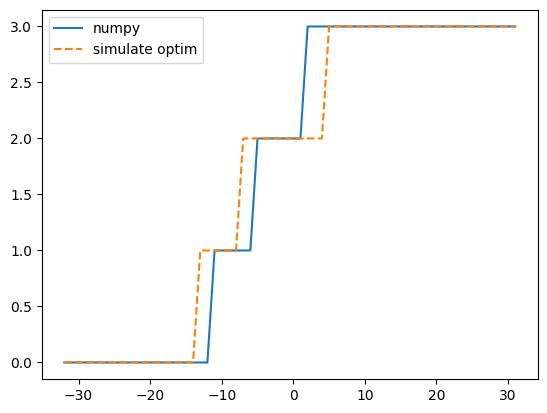

In [7]:
y_sim_optim = np.array([circuit_optim.simulate(elt) for elt in compile_input])[:, 0]
fig, ax = plt.subplots()
ax.plot(x, y, label="numpy",)
ax.plot(x, y_sim_optim, label="simulate optim", linestyle="--",)
plt.legend()
plt.show()
plt.close(fig)

In [8]:
stats = tlu_optimizer._statistics[0]
print(stats)

{'msbs_to_keep': 4, 'lsbs_to_remove': 19, 'a': array([87381]), 'b': array([87397])}


In [9]:
tx = x.copy()
tx = (tx * stats["a"]) - stats["b"]
print(f"{Integer.that_can_represent(tx).bit_width=}")
tx = rounding_function(tx, stats["lsbs_to_remove"])
tx = (tx + stats["b"]) / (stats["a"])
ty = f(tx)
print(f"{Integer.that_can_represent(x).bit_width=}")
x_round = rounding_function(x, Integer.that_can_represent(x).bit_width - stats["msbs_to_keep"])

Integer.that_can_represent(tx).bit_width=23
Integer.that_can_represent(x).bit_width=6


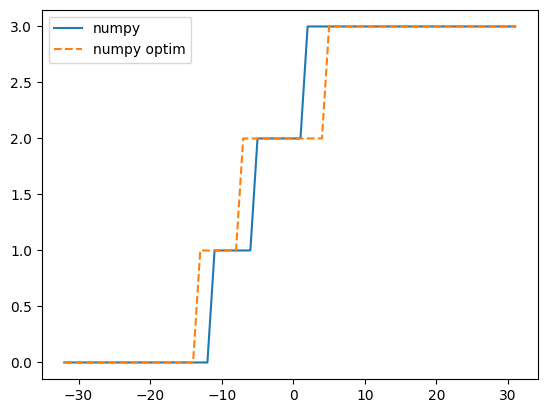

In [10]:
fig, ax = plt.subplots()
ax.plot(x, y, label="numpy",)
ax.plot(x, ty, label="numpy optim", linestyle="--",)
plt.legend()
plt.show()
plt.close(fig)

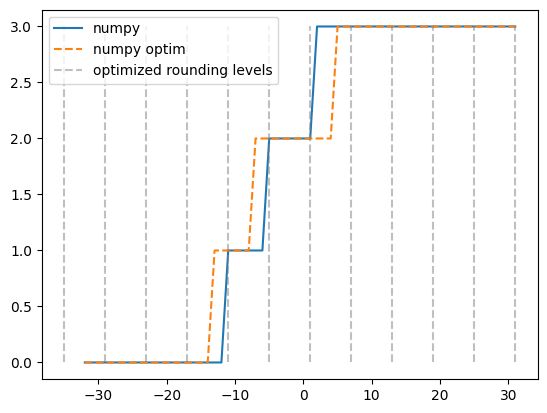

In [11]:
fig, ax = plt.subplots()
ax.plot(x, y, label="numpy",)
ax.plot(x, ty, label="numpy optim", linestyle="--",)
ax.vlines(np.unique(tx), y.min(), y.max(), label="optimized rounding levels", linestyle="--", color="grey", alpha=.5)
plt.legend()
plt.show()
plt.close(fig)

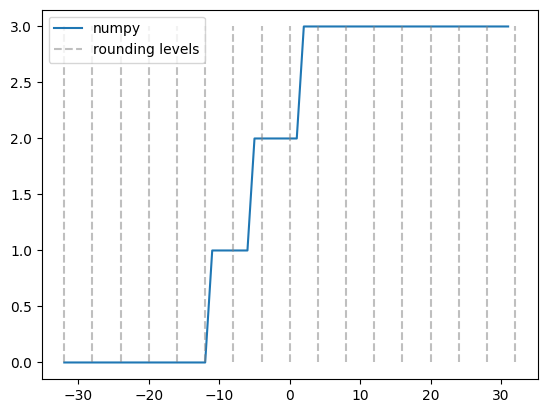

In [12]:
fig, ax = plt.subplots()
ax.plot(x, y, label="numpy",)
ax.vlines(np.unique(x_round), y.min(), y.max(), label="rounding levels", linestyle="--", color="grey", alpha=.5)
plt.legend()
plt.show()
plt.close(fig)

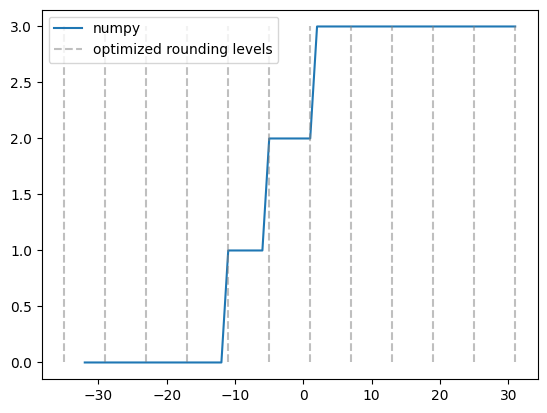

In [13]:
fig, ax = plt.subplots()
ax.plot(x, y, label="numpy",)
ax.vlines(np.unique(tx), y.min(), y.max(), label="optimized rounding levels", linestyle="--", color="grey", alpha=.5)
plt.legend()
plt.show()
plt.close(fig)

In [17]:
np.diff(np.arange(len(y)-1)[np.diff(y).astype(bool)])

array([6, 7])

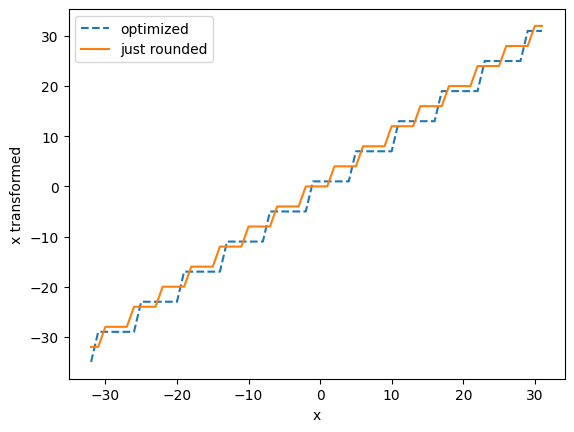

In [14]:
fig, ax = plt.subplots()
ax.set_xlabel("x")
ax.set_ylabel("x transformed")
ax.plot(x, tx, label="optimized", linestyle="--",)
ax.plot(x, x_round, label="just rounded",)
plt.legend()
plt.show()
plt.close(fig)